In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import pandas as pd
from google.colab.patches import cv2_imshow
import random

In [ ]:
# we are using 8000 images dataset
images_path = "/content/drive/MyDrive/Colab Notebooks/NNFL_research_paper/training_dataset"
csv_path = "/content/drive/MyDrive/Colab Notebooks/NNFL_research_paper/training_solutions_rev1.csv"

In [ ]:
df = pd.read_csv(csv_path)

In [ ]:
training_data = []

for img in os.listdir(images_path):
  name , extension = os.path.splitext(img) # name of the image
  x = cv2.imread(os.path.join(images_path,img),cv2.IMREAD_COLOR) # read the image

  y = df.loc[df['GalaxyID']==int(name)] # output vector based on ID number
  y = y.to_numpy() # converted to numpy
  y = y[0][1:] # dropping ID

  # preprocessing of images
  x = x[109:316, 109:316] # cropping from the center to make 207*207*3 
  x = cv2.resize(x,(69,69)) # resized to 69*69*3
  # color channels are preserved
 
  training_data.append([x,y])

8000
(69, 69, 3)


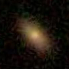

In [ ]:
# showing size and shape of the images in the pre-processed dataset
print(len(training_data))
print(training_data[0][0].shape)
cv2_imshow(training_data[0][0])

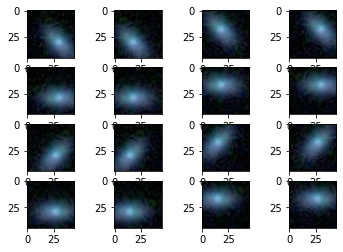

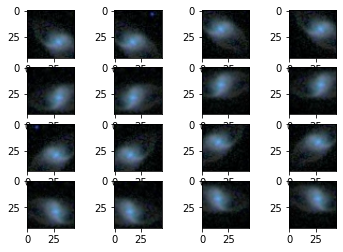

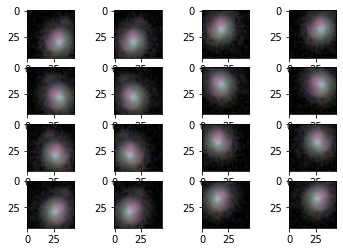

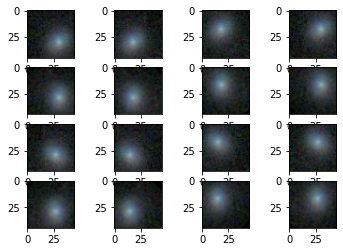

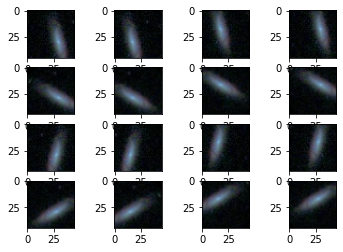

In [ ]:
# Viewpoint extrating of the images (69*69*3)
# final size of the viewpoints should be 45*45
# first cropping the images from the centers to 57*57 image size at 0 and 45 degrees
# then flipping both the crops to obtain four 57*57 sized images
# cropping from the four corners to obtain sixteen 45*45 sized images

expanded_dataset = []

for i in range(len(training_data)):

  # x0 is the intial image
  x0 = training_data[i][0]

  # xc1, xc2 are the two 57*57 cropped images
  xc1=  x0[5:62,5:62] # cropped at 0 degree
  h, w = x0.shape[:2]
  M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), 45, 1)
  xc2 = cv2.warpAffine(x0, M, (w, h))   
  xc2 = xc2[5:62,5:62] # 45 degree rotated crop

  # xf1, xf2 are flipped images of xc1, xc2
  xf1 = xc1[:, ::-1]
  xf2 = xc2[:, ::-1]

  # total 4 images xc1,xc2,xf1,xf2 and overall 16 viewpoints
  for p in [xc1,xc2,xf1,xf2]:
    # every image is cropped from 4 corners
    p1 = p[0:45,0:45]
    p2 = p[0:45,12:57]
    p3 = p[12:57,12:57]
    p4 = p[12:57,0:45]

    # appending p1,p2,p3,p4 in the feature set (x_train) with same label (y_train)
    expanded_dataset.append([p1,training_data[i][1]])
    expanded_dataset.append([p2,training_data[i][1]])
    expanded_dataset.append([p3,training_data[i][1]])
    expanded_dataset.append([p4,training_data[i][1]])

  # plotting 16 viewpoints of first 5 images
  if i%1000==0 :
    cols = 4
    rows = 4
    for k in range(0, rows):
      for j in range(0, cols):
        plt.subplot(rows,cols,k*cols+j+1)
        plt.imshow(expanded_dataset[i*16+k*cols+j][0].astype('uint8'))
      # show the plot
    plt.show()

In [ ]:
# printing length of the expanded dataset
print(len(expanded_dataset))

# shuffling the dataset 
random.shuffle(expanded_dataset)

# printing shape of images after viewpoint extraction
print(expanded_dataset[0][0].shape)
print(expanded_dataset[0][1].shape)

128000
(45, 45, 3)
(37,)


In [ ]:
x_train = [] # features
y_train = [] # labels

# seperating features and labels from expanded_dataset 
for feature, label in expanded_dataset:
  x_train.append(feature)
  y_train.append(label)

# converting to numpy array
x_train = np.array(x_train)
y_train = np.array(y_train)

# printing shapes of x_train, y_train
print(x_train.shape)
print(y_train.shape)

(128000, 45, 45, 3)
(128000, 37)


In [ ]:
# creating pickle file of the dataset after pre-processing and viewpoint extraction
# the final dataset will contain 1,28,000 images (45*45*3) which will be used for training the cnn model

import pickle
pickle_path = "/content/drive/MyDrive/Colab Notebooks/NNFL_research_paper/"

pickle_out = open(pickle_path + "x_train.pickle","wb")
pickle.dump(x_train, pickle_out)
pickle_out.close()

pickle_out = open(pickle_path + "y_train.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close() 